In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [21]:
%matplotlib inline
import pandas as pd
import os
import pymssql
import numpy as np
import mplfinance as mpf
from dotenv import load_dotenv

load_dotenv()

db_Password = os.getenv('PASSWORD')
db_settings = {
    "host": "127.0.0.1",
    "user": "SA",
    "password": db_Password,
    "database": "TutorialDB",
    "charset": "utf8"
}

True

In [22]:
def get_buy_or_sell(buy_or_sell, close):
    buy_points = []
    sell_points = []
    for date, value in buy_or_sell.iteritems():
        if value == 1:
            buy_points.append(close[date]*1.01)
            sell_points.append(np.nan)
        elif value == -1:
            sell_points.append(close[date]*0.99)
            buy_points.append(np.nan)
        else:
            sell_points.append(np.nan)
            buy_points.append(np.nan)
    return buy_points, sell_points

/var/folders/kp/0ndc__g55gsb1c902fr8k2k40000gn/T/ipykernel_85679/2409564938.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, value in buy_or_sell.iteritems():


Date
2021-01-04   NaN
2021-01-05   NaN
2021-01-06   NaN
2021-01-07   NaN
2021-01-08   NaN
              ..
2023-03-06   NaN
2023-03-07   NaN
2023-03-08   NaN
2023-03-09   NaN
2023-03-10   NaN
Name: buy_or_sell, Length: 529, dtype: float64


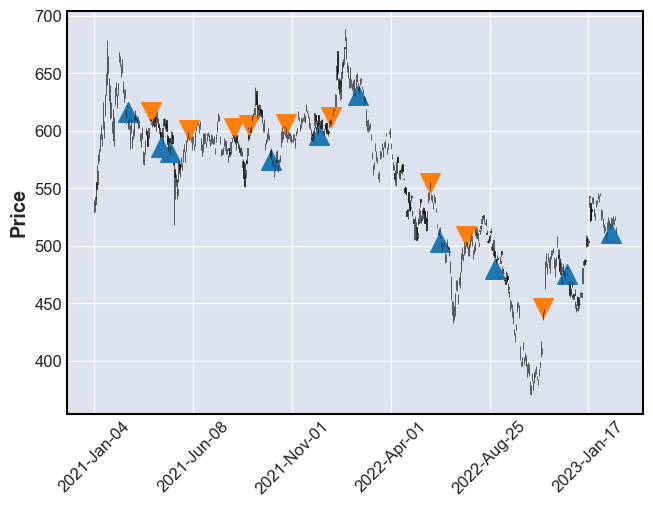

In [27]:
try:
    conn = pymssql.connect(**db_settings)
    # get stock data
    with conn.cursor() as cursor:
        command = "SELECT dbo.股價資訊.date, o, h, l, c, v, Buy_sell FROM [dbo].[股價資訊] left JOIN (SELECT * from dbo.GB_rule5('2330')) as t1 on dbo.股價資訊.date = t1.date where stock_code = '2330'"
        cursor.execute(command)
        result = cursor.fetchall()
        result = np.array(result)

        # define column names
        column_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'buy_or_sell']
        
        # get data and set index
        result_df = pd.DataFrame(result[:,1:], columns=column_names, index=result[:,0], dtype=float)
        result_df.index.name = 'Date'
        result_df.index = pd.to_datetime(result_df.index)
        # print(result_df)

        # get buy and sell  
        buy_arr, sell_arr = get_buy_or_sell(result_df['buy_or_sell'], result_df['Close'])

        apdict = [mpf.make_addplot(sell_arr,type='scatter',markersize=200,marker='^'),
                    mpf.make_addplot(buy_arr,type='scatter',markersize=200,marker='v'),
                    ]
        # print(len(result_df.index))
        mpf.plot(result_df,type='candle',addplot=apdict)
    conn.commit()
    conn.close()

except Exception as e:
    print(e)    